In [1]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [36]:
%pip install jax jaxlib

  Using cached jax-0.4.6.tar.gz (1.2 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 MB 2.8 MB/s eta 0:00:0000:0100:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached scipy-1.10.1-cp311-cp311-macosx_10_9_x86_64.whl (35.0 MB)
  Created wheel for jax: filename=jax-0.4.6-py3-none-any.whl size=1432714 sha256=9c4506d48c24717eb04e8f1b54064510e28d5ee3888f2ce6a6218063b510c006
  Stored in directory: /Users/g0bel1n/Library/Caches/pip/wheels/6a/28/40/ff10677acfec585e1716fbe856cf037a1f219f132df3b39b5a
Successfully built jax
Note: you may need to restart the kernel to use updated packages.


In [2]:
with open('../data/training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('../data/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('../data/training_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
    

In [3]:
import random
G1, G2 = random.choices(train_data, k=2)

In [4]:
class Walk:

    def __init__(self, path):
        self.path = path

    def __eq__(self, other):
        #recursively check if two walks are equal
        if len(self.path) != len(other.path):
            return False
        elif len(self.path) == 1:
            return self.path[0] == other.path[0]
        else:
            return self.path[0] == other.path[0] and self.path[1:] == other.path[1:]
        
    def __hash__(self):
        return hash(tuple(self.path))
    
def product_graph(G1, G2, edge_agg = np.sum):
        G = nx.Graph()
        for n1 in G1.nodes:
            for n2 in G2.nodes:
                if G1.nodes[n1]['labels'] == G2.nodes[n2]['labels']:
                    G.add_node((n1, n2), labels=G1.nodes[n1]['labels'])
        for e1 in G1.edges:
            for e2 in G2.edges:
                if (e1[0], e2[0]) in G.nodes and (e1[1], e2[1]) in G.nodes:
                    G.add_edge((e1[0], e2[0]), (e1[1], e2[1]), labels=[edge_agg((G1.edges[e1]['labels'],G1.edges[e1]['labels']))])
        return G


def normalize_adjacency_matrix(A):
    D = np.diag(np.sum(A, axis=0))
    return np.linalg.inv(D) @ A


def draw_molecule(G, **kwargs):
    pos = nx.spring_layout(G) if 'pos' not in kwargs else kwargs.pop('pos')
    
    nx.draw(G,pos=pos, width = [G.edges[e]['labels'][0]+1 for e in G.edges], **kwargs)
    kwargs = {k:v for k,v in kwargs.items() if k in nx.draw_networkx_labels.__code__.co_varnames}
    nx.draw_networkx_labels(G, pos=pos, labels={n:G.nodes[n]['labels'][0] for n in G.nodes}, **kwargs)



In [116]:
from abc import ABC, abstractmethod
import networkx as nx
import numpy as np

from typing import List, Optional, Any
from tqdm import tqdm

from scipy.sparse.linalg import cg
from scipy.sparse import identity


class GraphKernel(ABC):

    def __init__(self):
        pass


    def __call__(self, x1, x2):
        if isinstance(x1, nx.Graph) and isinstance(x2, nx.Graph):
            return self._kernel(x1, x2)
        elif isinstance(x1, list) and isinstance(x2, list):
            return np.array([[self._kernel(x1[i], x2[j]) for i in range(len(x1))] for j in range(len(x2))])


    @abstractmethod
    def _kernel(self, G1: nx.Graph, G2: nx.Graph):
        pass


class SubKernel(ABC):
    
        def __init__(self):
            pass
    
        @abstractmethod
        def _kernel(self, sub1, sub2):
            pass
    
        def __call__(self, sub1, sub2) -> Any:
            return self._kernel(sub1, sub2)
        
class EdgeKernel(SubKernel):
    pass

class NodeKernel(SubKernel):
    pass

class LinearEdgeKernel(EdgeKernel):

    def _kernel(self, sub1, sub2):
        return int(sub1==sub2)*sub1
    
class QuadraticEdgeKernel(EdgeKernel):

    def _kernel(self, sub1, sub2):
        return (int(sub1==sub2)*sub1)**2
    
class BinaryNodeKernel(NodeKernel):

    def _kernel(self, sub1, sub2):
        return int(sub1==sub2)

    
    


class RandomWalkKernel(GraphKernel):
    def __init__(self, edge_kernel: Optional[EdgeKernel] = None, node_kernel: Optional[BinaryNodeKernel] = None, normalize=False, node_labels=True, c:float = .1):

        self.edge_kernel = edge_kernel or LinearEdgeKernel()
        self.node_kernel = node_kernel or BinaryNodeKernel()
        self.normalize = normalize
        self.node_labels = node_labels
        self.c = c
        

    def _kernel(self, G1 : nx.Graph, G2 : nx.Graph):
        p1, q1 = np.ones(len(G1.nodes)), np.ones(len(G1.nodes))
        p2, q2 = np.ones(len(G2.nodes)), np.ones(len(G2.nodes))
        p, q = np.kron(p1, p2), np.kron(q1, q2)
        
        #
        if self.node_labels:
            W = np.zeros((len(G1.nodes)*len(G2.nodes), len(G1.nodes)*len(G2.nodes)))
            for e1 in G1.edges(data=True):
                for e2 in G2.edges(data=True):
                    idx = (e1[0]*len(G2.nodes)+e2[0], e1[1]*len(G2.nodes)+e2[1])
                    W[idx] = self.edge_kernel(e1[2]['labels'][0], e2[2]['labels'][0]) * (self.node_kernel(G1.nodes[e1[0]]['labels'][0], G2.nodes[e2[0]]['labels'][0]) 
                                                                                    * self.node_kernel(G1.nodes[e1[1]]['labels'][0], G2.nodes[e2[1]]['labels'][0]) 
                                                                                    + self.node_kernel(G1.nodes[e1[0]]['labels'][0], G2.nodes[e2[1]]['labels'][0]) 
                                                                                    * self.node_kernel(G1.nodes[e1[1]]['labels'][0], G2.nodes[e2[0]]['labels'][0])
                                                                                    )
                    W[idx[::-1]] = W[idx]

                    idx2 = (e1[0]*len(G2.nodes)+e2[1], e1[1]*len(G2.nodes)+e2[0])
                    W[idx2] = W[idx]
                    W[idx2[::-1]] = W[idx]
        else:
            if self.normalize:
                A1, A2 = normalize_adjacency_matrix(nx.adjacency_matrix(G1).todense()), normalize_adjacency_matrix(nx.adjacency_matrix(G2).todense())
            else:
                A1, A2 = nx.adjacency_matrix(G1).todense(), nx.adjacency_matrix(G2).todense()
            W = np.kron(A1.T, A2.T)


        x, _ = cg(identity(W.shape[0])-self.c*W, p)

        return x @ q

    

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.edge_kernel.__name__}, {self.node_kernel.__name__}, {self.normalize}, {self.node_labels}, {self.c})"


def nx_shortest_path_2_array(sp, n_nodes: int):
    """
    Convert a dictionary of shortest path lengths to a numpy array.

    Parameters
    ----------
    sp : dict
        A dictionary of shortest path lengths.

    Returns
    -------
    s : numpy.array
        A numpy array of shortest path lengths.
    """

    sp = dict(sp)
    arr = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(i, n_nodes):
            if i in sp and j in sp[i]:
                arr[i, j] = sp[i][j]
                arr[j, i] = sp[j][i]
    return arr

class ShortestPathKernel(GraphKernel):

    def _kernel(self, G1, G2):
        """
        Compute the kernel value (similarity) between two graphs.

        Parameters
        ----------
        g_1 : networkx.Graph
            First graph.
        g_2 : networkx.Graph
            Second graph.

        Returns
        -------
        k : The similarity value between g_1 and g_2.
        """
        # Compute the shortest path lengths between all pairs of nodes in each graph
        sp1 = nx.shortest_path_length(G1)
        sp2 = nx.shortest_path_length(G2)

        

        # Create an array of the shortest path lengths for each graph
        s1 = nx_shortest_path_2_array(sp1, len(G1.nodes))
        s2 = nx_shortest_path_2_array(sp2, len(G2.nodes))

        nbins = max(s1.max(), s2.max()) + 2

        # Compute the histogram of the shortest path lengths for each graph
        h1 = np.histogram(s1, bins=np.arange(nbins),density=True )[0]
        h2 = np.histogram(s2, bins=np.arange(nbins), density=True)[0]

        # Compute the dot product of the histogram vectors
        return np.dot(h1, h2)

class nthOrderKernel(GraphKernel):
    def __init__(self, n: int = 5):
        self.n = n

    def _kernel(self, G1, G2):
        Gx = product_graph(G1, G2)

        A = nx.adjacency_matrix(Gx).todense()
        one_vec = np.ones(A.shape[0])
        return one_vec @ np.linalg.matrix_power(A, self.n) @ one_vec

    

    


In [117]:
class knn:
        
        def __init__(self, kernel, k=3) -> None:
            self.k = k
            self.kernel = kernel
            
        def fit(self, X, y):
            self.X = X
            self.y = y

            return self
        
        def compute_distance(self, x, base):
            k = self.kernel(x,x)
            return [k+self.kernel(b,b)-2*self.kernel(x, b) for b in base]
        
        def predict(self, X):
            y_pred = []
            score_list = []
            for x in tqdm(X):
                scores = np.array(self.compute_distance(x, self.X))
                idx = np.argsort(scores)[:self.k]
                y_pred.append((self.y[idx].mean()>.5).astype(int))
                score_list.append(scores)
            return np.array(y_pred), np.array(score_list)
        
        def score(self, X, y):
            return np.mean(self.predict(X)[0]==y)

In [118]:
idx1 = train_labels==1
idx0 = train_labels==0

train_data = np.array(train_data, dtype=object)

X_train = train_data[idx1][:30]
X_train = np.concatenate((X_train, train_data[idx0][:30]))
y_train = np.concatenate((np.ones(30), np.zeros(30)))

X_test = train_data[idx1][30:60]
X_test = np.concatenate((X_test, train_data[idx0][30:60]))
y_test = np.concatenate((np.ones(30), np.zeros(30)))




In [121]:
knn_ = knn(k=3, kernel=RandomWalkKernel(edge_kernel=QuadraticEdgeKernel())).fit(X_train, y_train)
a = knn_.predict(X_test)

100%|██████████| 60/60 [02:01<00:00,  2.03s/it]


In [122]:
np.mean(a[0]==y_test)

0.6

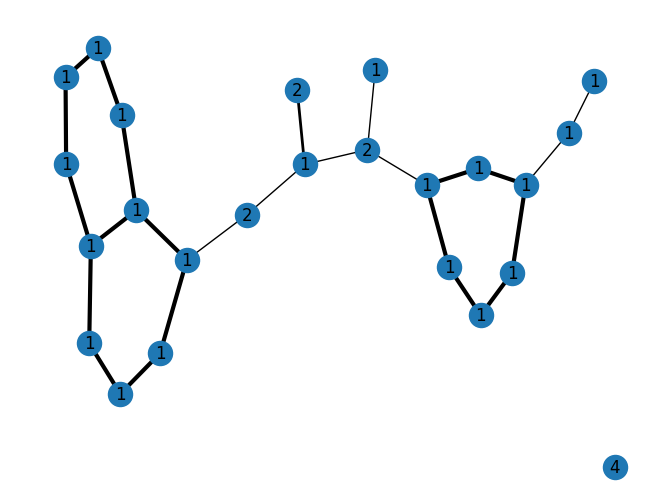

In [20]:
pos2 = nx.spring_layout(G2)
draw_molecule(G2, pos=pos)

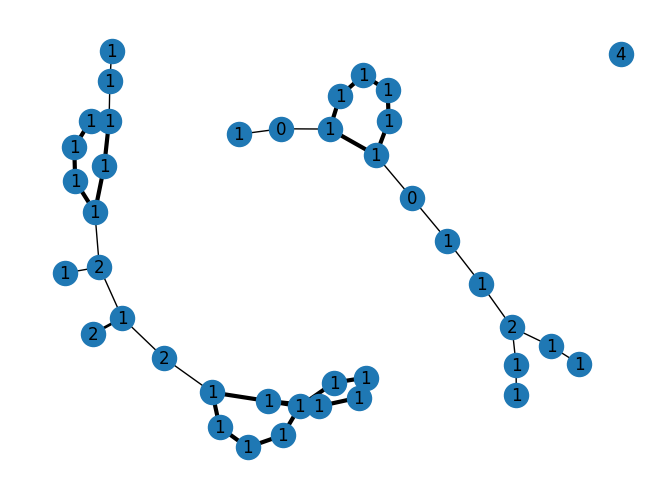

In [24]:
# product graph 

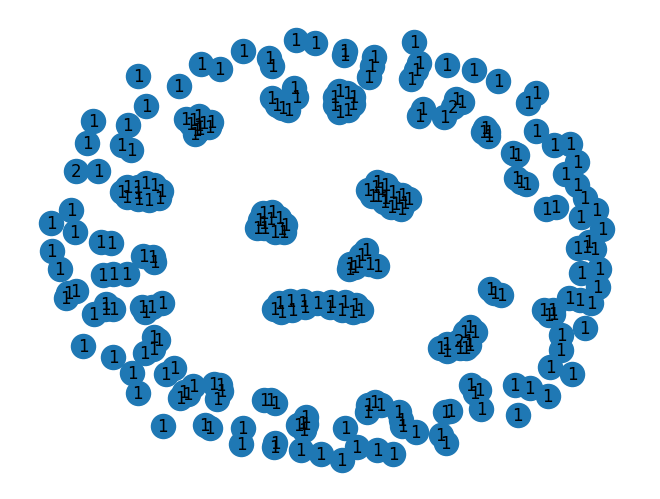

In [308]:
def product_graph(G1, G2):
    G = nx.Graph()
    for n1 in G1.nodes:
        for n2 in G2.nodes:
            if G1.nodes[n1]['labels'] == G2.nodes[n2]['labels']:
                G.add_node((n1, n2), labels=G1.nodes[n1]['labels'])
    for e1 in G1.edges:
        for e2 in G2.edges:
            if (e1[0], e2[0]) in G.nodes and (e1[1], e2[1]) in G.nodes:
                G.add_edge((e1[0], e2[0]), (e1[1], e2[1]), labels=[np.max((G1.edges[e1]['labels'],G1.edges[e1]['labels']))])
    return G

In [164]:
def _random_walk(G : nx.Graph, len_max: int):
        """
        Random walk on graph G, starting from node 0, with maximum length len_max
        """
        idx= np.random.choice(np.arange(len(G.nodes)))
        path = [list(G.nodes)[idx]]
        for _ in range(len_max):
            if neighbors := list(G.neighbors(path[-1])):
                idx = np.random.choice(np.arange(len(neighbors)))
                path.append(neighbors[idx])
            else:
                break
        return Walk(path)

In [8]:
class Walk:

    def __init__(self, path):
        self.path = path

    def __eq__(self, other):
        #recursively check if two walks are equal
        if len(self.path) != len(other.path):
            return False
        elif len(self.path) == 1:
            return self.path[0] == other.path[0]
        else:
            return self.path[0] == other.path[0] and self.path[1:] == other.path[1:]
        
    def __hash__(self):
        return hash(tuple(self.path))
    


In [380]:
kern = kernel

kern(G1,G1)+ kern(G2,G2) - 2*kern(G1,G2)

180.74591160496698